In [1]:
# Importation des librairies
from webscraping.ws_fonctions import *
from nettoyage_fonctions import *

import seaborn as sns
import matplotlib.pyplot as plt


# Regression
import statsmodels.api as sm
from statsmodels.formula.api import rlm # => pour regression robuste à hétéroscédasticité

## Création de la base de données

### Webscrapping AlloCiné

In [2]:
# En récupérant par année
data_2010 = get_comparaison_notes(2010) 
data_2011 = get_comparaison_notes(2011) 
data_2012 = get_comparaison_notes(2012)


nombre de films récupérés :  491
nombre de films récupérés :  518
nombre de films récupérés :  522


In [3]:
base_films = pd.concat([data_2010,data_2011, data_2012])
base_films

,titre,date,durée,auteur,spectateur,presse,genre1,genre2,genre3
0,Incendies,12 janvier 2011,2h 03min,Denis Villeneuve,"4,3","3,8",Drame,,
1,Shutter Island,24 février 2010,2h 17min,Martin Scorsese,"4,4","3,8",Thriller,,
2,Robin des Bois,12 mai 2010,2h 20min,Ridley Scott,"3,2","3,4",Action,Aventure,
3,L'Agence tous risques,16 juin 2010,1h 54min,Joe Carnahan,"3,2","3,2",Action,Comédie,
4,Dragons,31 mars 2010,1h 33min,Chris Sanders,"4,3","3,9",Aventure,Animation,Famille
...,...,...,...,...,...,...,...,...,...
517,Micmac Masters,5 novembre 2014,2h 05min,Nalan Kumarasamy,"3,6","2,7",Comédie dramatique,Thriller,
518,"Ini Avan, Celui qui revient",10 juillet 2013,1h 44min,Asoka Handagama,"3,3","3,6",Drame,,
519,Chronique d'une vie...Cronica Del Fin Del Mundo,14 septembre 2016,1h 25min,Mauricio Cuervo,"3,0","2,6",Drame,,
520,Shapito Show - Partie 1,16 juillet 2014,1h 46min,Sergei Loban,"3,8","3,2",Comédie,Musical,


### Ajout et création de variables

In [105]:
# Ajout du genre des réalisateurs

table_avec_genre = get_genre_individuel(base_films, 'auteur')
table_avec_genre = table_avec_genre.drop(columns=['prenom','langage_ind'])
table_avec_genre['genre_ind'].value_counts()


genre_ind
m      957
f      166
m,f     48
f,m     14
Name: count, dtype: int64

In [106]:
table_avec_genre.head()

,genre_ind,titre,date,durée,auteur,spectateur,presse,genre1,genre2,genre3
0,m,4h44 Dernier jour sur terre,19 décembre 2012,1h 22min,Abel Ferrara,"2,2","3,3",Drame,Science Fiction,
1,m,Very Bad Cops,27 octobre 2010,1h 47min,Adam McKay,"2,5","3,3",Action,Comédie,
2,m,You're Next,4 septembre 2013,1h 35min,Adam Wingard,"3,0","3,3",Epouvante-horreur,,
3,m,Rock Forever,11 juillet 2012,2h 02min,Adam Shankman,"2,9","2,5",Comédie dramatique,Comédie musicale,
4,m,Gimme the Loot,2 janvier 2013,1h 21min,Adam Leon,"2,9","3,6",Drame,,


In [107]:
# Transformation des types de films en variables dummy 

dummies1 = pd.get_dummies(table_avec_genre['genre1'], prefix='genre')
dummies2 = pd.get_dummies(table_avec_genre['genre2'], prefix='genre')
dummies3 = pd.get_dummies(table_avec_genre['genre3'], prefix='genre')

dummies1 = dummies1.astype(int)
dummies2 = dummies2.astype(int)
dummies3 = dummies3.astype(int)

dummies_sum = dummies1.add(dummies2, fill_value=0).add(dummies3, fill_value=0)
dummies_sum = dummies_sum.drop(columns=['genre_'])

df = pd.concat([table_avec_genre, dummies_sum], axis=1)
print('nombre de films pris en compte :', len(df))

nombre de films pris en compte : 1185


In [108]:
# Conversion des notes en décimale
table_avec_genre['spectateur'] = table_avec_genre['spectateur'].apply(mise_en_forme_decimale)
table_avec_genre['presse'] = table_avec_genre['presse'].apply(mise_en_forme_decimale)

In [109]:
# Création variable : différence de notation entre spectateur et presse
table_avec_genre['diff_notation'] = table_avec_genre['spectateur']-table_avec_genre['presse']
table_avec_genre.head()


,genre_ind,titre,date,durée,auteur,spectateur,presse,genre1,genre2,genre3,diff_notation
0,m,4h44 Dernier jour sur terre,19 décembre 2012,1h 22min,Abel Ferrara,2.2,3.3,Drame,Science Fiction,,-1.1
1,m,Very Bad Cops,27 octobre 2010,1h 47min,Adam McKay,2.5,3.3,Action,Comédie,,-0.8
2,m,You're Next,4 septembre 2013,1h 35min,Adam Wingard,3.0,3.3,Epouvante-horreur,,,-0.3
3,m,Rock Forever,11 juillet 2012,2h 02min,Adam Shankman,2.9,2.5,Comédie dramatique,Comédie musicale,,0.4
4,m,Gimme the Loot,2 janvier 2013,1h 21min,Adam Leon,2.9,3.6,Drame,,,-0.7


In [111]:
# Conversion de la durée en minutes
table_avec_genre['durée'] = table_avec_genre['durée'].astype('string')
table_avec_genre['duree_min'] = table_avec_genre['durée'].apply(duree_en_minutes)

## Quelques graphes....

Text(0, 0.5, 'Fréquence')

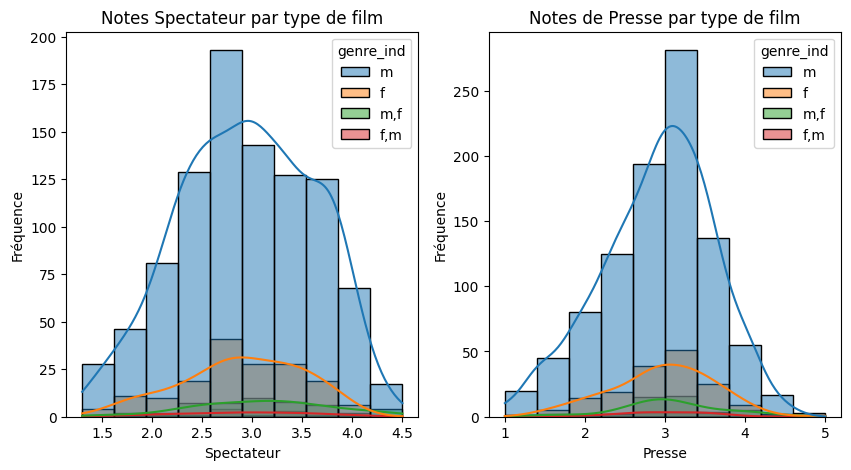

In [115]:
df = table_avec_genre
fig, axes = plt.subplots(1,2, figsize=(10, 5))

# Histogramme des notes SPECTATEUR par type de film
sns.histplot(data=df, x='spectateur', hue='genre_ind', bins=10, kde=True, ax=axes[0])
axes[0].set_title('Notes Spectateur par type de film')
axes[0].set_xlabel('Spectateur')
axes[0].set_ylabel('Fréquence')

# Histogramme des notes PRESSE par du type de film
sns.histplot(data=df, x='presse', hue='genre_ind', bins=10, kde=True, ax=axes[1])
axes[1].set_title('Notes de Presse par type de film')
axes[1].set_xlabel('Presse')
axes[1].set_ylabel('Fréquence')

Text(0, 0.5, 'Fréquence')

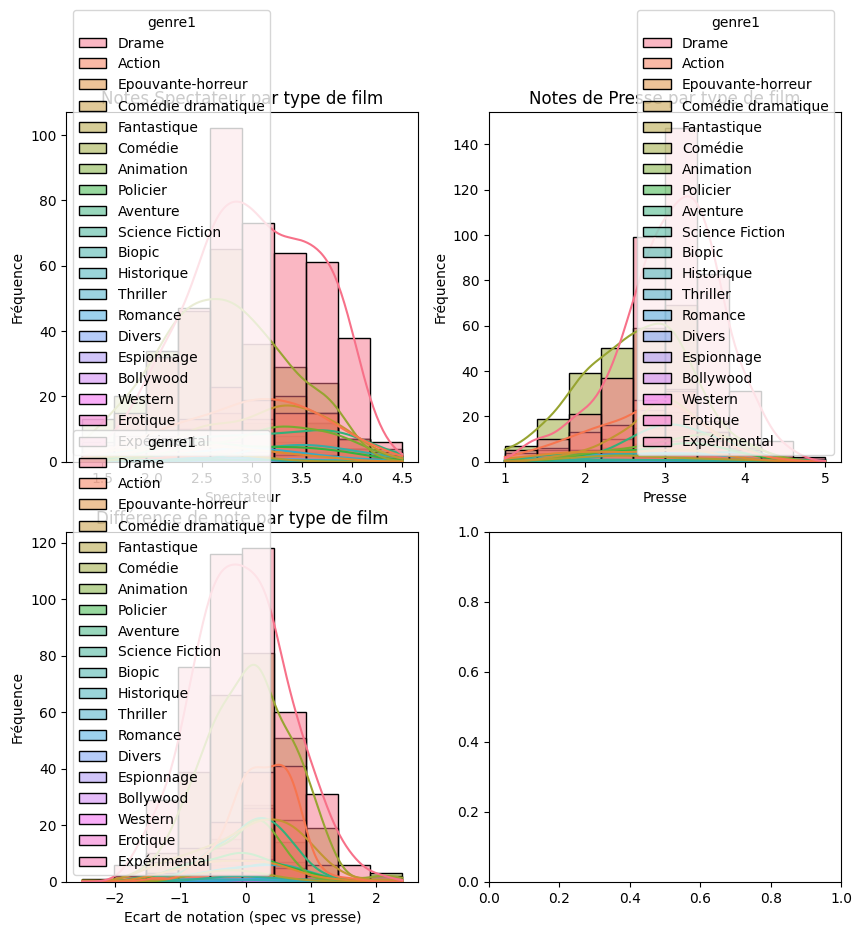

In [116]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Histogramme des notes SPECTATEUR par type de film
sns.histplot(data=df, x='spectateur', hue='genre1', bins=10, kde=True, ax=axes[0,0])
axes[0,0].set_title('Notes Spectateur par type de film')
axes[0,0].set_xlabel('Spectateur')
axes[0,0].set_ylabel('Fréquence')

# Histogramme des notes PRESSE par du type de film
sns.histplot(data=df, x='presse', hue='genre1', bins=10, kde=True, ax=axes[0,1])
axes[0,1].set_title('Notes de Presse par type de film')
axes[0,1].set_xlabel('Presse')
axes[0,1].set_ylabel('Fréquence')


# Histogramme des DIFFERENCE de par type de film
sns.histplot(data=df, x='diff_notation', hue='genre1', bins=10, kde=True, ax=axes[1,0])
axes[1,0].set_title('Différence de note par type de film')
axes[1,0].set_xlabel('Ecart de notation (spec vs presse)')
axes[1,0].set_ylabel('Fréquence')


## Test de modèles sur la différence de notation

### ANOVA (sur premier genre)

### Regression

- Notes spectateurs

In [122]:
# Définir les variables dépendantes et indépendantes
X = df[['duree_min', 'genre_Action', 'genre_Animation', 'genre_Policier', 'genre_Thriller', 'genre_Science Fiction', 'genre_Drame', 'genre_Aventure']]
y = df['spectateur']
X = sm.add_constant(X)

# Régression linéaire OLS
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             spectateur   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     15.89
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           2.22e-19
Time:                        19:22:41   Log-Likelihood:                -256.63
No. Observations:                 296   AIC:                             531.3
Df Residuals:                     287   BIC:                             564.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.71

- Notes presse

In [124]:
# Définir les variables dépendantes et indépendantes
X = df[['duree_min', 'genre_Action', 'genre_Animation', 'genre_Policier', 'genre_Thriller', 'genre_Science Fiction', 'genre_Drame', 'genre_Aventure']]
y = df['presse']
X = sm.add_constant(X)

# Régression linéaire OLS
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 presse   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     17.38
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           4.49e-21
Time:                        19:23:34   Log-Likelihood:                -216.55
No. Observations:                 296   AIC:                             451.1
Df Residuals:                     287   BIC:                             484.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.29

- Différences de notations

In [125]:
# Définir les variables dépendantes et indépendantes
X = df[['duree_min', 'genre_Action', 'genre_Animation', 'genre_Policier', 'genre_Thriller', 'genre_Science Fiction', 'genre_Drame', 'genre_Aventure']]
y = df['diff_notation']
X = sm.add_constant(X)

# Régression linéaire OLS
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          diff_notation   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.929
Date:                Sun, 03 Nov 2024   Prob (F-statistic):             0.0556
Time:                        19:25:00   Log-Likelihood:                -226.63
No. Observations:                 296   AIC:                             471.3
Df Residuals:                     287   BIC:                             504.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.57

In [126]:
# test robuste à l'hétéroscédasticité ?
model = rlm("diff_notation ~ duree_min + genre_Action + genre_Animation+genre_Policier+genre_Fantastique+genre_Drame+genre_Aventure", data=df).fit()
print(model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          diff_notation   No. Observations:                  296
Model:                            RLM   Df Residuals:                      288
Method:                          IRLS   Df Model:                            7
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Nov 2024                                         
Time:                        19:25:14                                         
No. Iterations:                    16                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5961      0.18